# **Insper - Projeto de Eletromagnetismo e Ondulatória - 2022.2** #

Jerônimo Afrange, Matheus Barros, Pedro Altobelli, Thiago Kawahara

## Etapa 1.1

### > Diagrama do modelo eletrodinâmico do circuito WPT

<img src="diagrama.jpeg" alt="Diagrama do circuito"/>

In [1]:
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt

### > Constantes

In [2]:
# indutâncias das bobinas (Henries)
INDUTANCIA_PRIMARIA   = 138.6e-6
INDUTANCIA_SECUNDARIA = 144.3e-6

# capacitâncias dos capacitores (Farads)
CAPACITANCIA_PRIMARIA   = 0.1e-6
CAPACITANCIA_SECUNDARIA = 0.1e-6

# resistências das bobinas e da carga (Ohms)
RESISTENCIA_PRIMARIA   = 0.817 * 4.34   # o 4.35 é para considerar a resistência dos jumpers
RESISTENCIA_SECUNDARIA = 0.875 * 4.34   # o 4.35 é para considerar a resistência dos jumpers
RESISTENCIA_CARGA      = 100

### > Definição de funções úteis

In [3]:
def calc_impedancia_capacitiva(capacitancia, frequencia_angular):
    return -1j * 1 / (capacitancia * frequencia_angular)

def calc_impedancia_indutiva(indutancia, frequencia_angular):
    return 1j * indutancia * frequencia_angular

def calc_frequencia_angular(frequencia):
    return 2 * math.pi * frequencia

def calc_indutancia_mutua(indutancia_primaria, indutancia_secundaria, fator_acoplamento):
    return fator_acoplamento * math.sqrt(indutancia_primaria * indutancia_secundaria)

def calc_frequencia(frequencia_angular):
    return frequencia_angular / (2 * math.pi)

def calc_arranjo_paralelo(*impedancias):
    admitancia_acumulada = 0
    for impedancia in impedancias: admitancia_acumulada += 1 / impedancia
    return 1 / admitancia_acumulada

def calc_arranjo_serial(*impedancias):
    impedancia_acumulada = 0
    for impedancia in impedancias: impedancia_acumulada += impedancia
    return impedancia_acumulada

### > Cálculos secundários

In [4]:
# frequência de resonância do transformador
FREQUENCIA_ANGULAR_RESONANTE = abs(1 / math.sqrt(INDUTANCIA_PRIMARIA * CAPACITANCIA_PRIMARIA))
FREQUENCIA_RESONANTE = calc_frequencia(FREQUENCIA_ANGULAR_RESONANTE)

# verbose dos valores
print('Frequência de resonância do transformador:\t%.2f Hz' % round(FREQUENCIA_RESONANTE, 2))


Frequência de resonância do transformador:	42750.24 Hz


## Etapa 1.2

### > Código do modelo numérico

In [5]:
def calcular_transformador(tensao_pico_fonte, frequencia, fator_acoplamento):
    '''
    Calcula diversos valores de diversas grandezas no transformador.
    
    Parâmetros:
    - tensao_pico_fonte (num):   tensão de pico da onda quadrada da fonte
    - frequencia        (num):   frequência da tensão da fonte
    - fator_acoplamento (float): valor de 0 a 1 do fator de acoplamento do transformador
    
    Retorna:
    - resultados (dict(str->num)):
        - "corrente-primaria"  : corrente que percorre a bobina primária
        - "corrente-secundaria": corrente que percorre a bobina secundária
        - "tensao-carga"       : tensão nos terminais da carga
        - "corrente-carga"     : corrente nos terminais da carga
        - "potencia-entrada"   : potência total consumida pelo sistema
        - "potencia-saida"     : potência total disponível na carga
        - "eficiencia"         : eficiência energética do sistema
    
    '''
    
    # define o dicionário de retorno
    resultados = dict()
    
    # calcula a frequência angular da fonte
    frequencia_angular = calc_frequencia_angular(frequencia)
    
    # calcula as impedâncias do transformador
    impedancia_indutor_primaria = calc_impedancia_indutiva(INDUTANCIA_PRIMARIA, frequencia_angular)
    impedancia_indutor_secundaria = calc_impedancia_indutiva(INDUTANCIA_SECUNDARIA, frequencia_angular)
    impedancia_capacitor_primaria = calc_impedancia_capacitiva(CAPACITANCIA_PRIMARIA, frequencia_angular)
    impedancia_capacitor_secundaria = calc_impedancia_capacitiva(CAPACITANCIA_SECUNDARIA, frequencia_angular)
    
    # cálculo da impedância mútua do transformador
    indutancia_mutua = calc_indutancia_mutua(INDUTANCIA_PRIMARIA, INDUTANCIA_SECUNDARIA, fator_acoplamento)
    impedancia_mutua = calc_impedancia_indutiva(indutancia_mutua, frequencia_angular)
    
    # calcula a impedância equivalente da carga e do capacitor da secundária
    impedancia_capacitor_carga = calc_arranjo_paralelo(impedancia_capacitor_secundaria, RESISTENCIA_CARGA)
    
    # calcula valores de tensão relevantes
    tensao_fonte_corrigida = tensao_pico_fonte * 2 / math.pi
    
    # calcula as impedâncias combinadas
    impedancia_primaria = calc_arranjo_serial(RESISTENCIA_PRIMARIA, impedancia_indutor_primaria, impedancia_capacitor_primaria)
    impedancia_secundaria = calc_arranjo_serial(RESISTENCIA_SECUNDARIA, impedancia_indutor_secundaria, impedancia_capacitor_carga)
    
    # definicão da matriz de impedâncias
    matriz_impedancias = np.array(
        [ [ impedancia_primaria,  -1 * impedancia_mutua ],
          [-1 * impedancia_mutua, impedancia_secundaria ] ]
    )
    
    # definição da matriz de tensões
    matriz_tensoes = np.array([tensao_fonte_corrigida, 0])
    
    # cálculo da matriz das correntes
    matriz_correntes = np.dot(np.linalg.inv(matriz_impedancias), matriz_tensoes)
    
    # coloca os valores obtidos no dicionário de resultados
    resultados['corrente-primaria'] = matriz_correntes[0]
    resultados['corrente-secundaria'] = matriz_correntes[1]
    resultados['tensao-carga'] = impedancia_capacitor_carga * matriz_correntes[1]
    resultados['corrente-carga'] = resultados['tensao-carga'] / RESISTENCIA_CARGA
    resultados['potencia-entrada'] = abs(tensao_fonte_corrigida * matriz_correntes[0].conjugate()) / 2
    resultados['potencia-saida'] = (resultados['tensao-carga'] * resultados['corrente-carga'].conjugate()).real / 2
    resultados['eficiencia'] = resultados['potencia-saida'] / resultados['potencia-entrada']
    
    return resultados

## Cálculo para os gráficos

### > Variando a frequência

In [6]:
tensao_pico = 5 # Volts

In [7]:
fator_acoplamento = 0.208

# listas de armazenamento dos resultados
eficiencias_f = list()
tensoes_carga_f = list()
correntes_carga_f = list()
potencias_saida_f = list()
potencias_entrada_f = list()
correntes_primaria_f = list()
correntes_secundaria_f = list()

# valores máximos e respectivos valores de frequência
eficiencia_max_f = 0
tensao_carga_max_f = 0
corrente_carga_max_f = 0
potencia_saida_max_f = 0
potencia_entrada_max_f = 0
corrente_primaria_max_f = 0
corrente_secundaria_max_f = 0
f_eficiencia_max_f = 0
f_tensao_carga_max_f = 0
f_corrente_carga_max_f = 0
f_potencia_saida_max_f = 0
f_potencia_entrada_max_f = 0
f_corrente_primaria_max_f = 0
f_corrente_secundaria_max_f = 0

# lista de frequências a serem usadas
frequencias = list(np.linspace(1, 2 * FREQUENCIA_RESONANTE, 100000))

# loop de computação
for frequencia in frequencias:
    
    # cálculo dos valores
    resultados = calcular_transformador(tensao_pico, frequencia, fator_acoplamento)
    
    # armazenamento nas listas
    eficiencias_f.append(resultados['eficiencia'])
    tensoes_carga_f.append(resultados['tensao-carga'])
    correntes_carga_f.append(resultados['corrente-carga'])
    potencias_saida_f.append(resultados['potencia-saida'])
    potencias_entrada_f.append(resultados['potencia-entrada'])
    correntes_primaria_f.append(resultados['corrente-primaria'])
    correntes_secundaria_f.append(resultados['corrente-secundaria'])
    
    # localização do valor máximo de eficiência
    if resultados['eficiencia'] > eficiencia_max_f:
        eficiencia_max_f = resultados['eficiencia']
        f_eficiencia_max_f = frequencia
        
    # localização do valor máximo de tensão na carga
    if resultados['tensao-carga'] > tensao_carga_max_f:
        tensao_carga_max_f = resultados['tensao-carga']
        f_tensao_carga_max_f = frequencia
        
    # localização do valor máximo de corrente na carga
    if resultados['corrente-carga'] > corrente_carga_max_f:
        corrente_carga_max_f = resultados['corrente-carga']
        f_corrente_carga_max_f = frequencia
        
    # localização do valor máximo de potência na saída
    if resultados['potencia-saida'] > potencia_saida_max_f:
        potencia_saida_max_f = resultados['potencia-saida']
        f_potencia_saida_max_f = frequencia
        
    # localização do valor máximo de potência na entrada
    if resultados['potencia-entrada'] > potencia_entrada_max_f:
        potencia_entrada_max_f = resultados['potencia-entrada']
        f_potencia_entrada_max_f = frequencia
    
    # localização do valor máximo da corrente primária
    if resultados['corrente-primaria'] > corrente_primaria_max_f:
        corrente_primaria_max_f = resultados['corrente-primaria']
        f_corrente_primaria_max_f = frequencia
    
    # localização do valor máximo da corrente secundária
    if resultados['corrente-secundaria'] > corrente_secundaria_max_f:
        corrente_secundaria_max_f = resultados['corrente-secundaria']
        f_corrente_secundaria_max_f = frequencia
        
        

### > Variando o fator de acoplamento na frequência resonante

In [8]:
# listas de armazenamento dos resultados
eficiencias_k = list()
tensoes_carga_k = list()
correntes_carga_k = list()
potencias_saida_k = list()
potencias_entrada_k = list()
correntes_primaria_k = list()
correntes_secundaria_k = list()

# valores máximos e respectivos valores de frequência
eficiencia_max_k = 0
tensao_carga_max_k = 0
corrente_carga_max_k = 0
potencia_saida_max_k = 0
potencia_entrada_max_k = 0
corrente_primaria_max_k = 0
corrente_secundaria_max_k = 0
k_eficiencia_max_k = 0
k_tensao_carga_max_k = 0
k_corrente_carga_max_k = 0
k_potencia_saida_max_k = 0
k_potencia_entrada_max_k = 0
k_corrente_primaria_max_k = 0
k_corrente_secundaria_max_k = 0

# lista de fatores de acoplamento a serem usados
fatores_acoplamento = list(np.linspace(0, 1, 100000))

# loop de computação
for fator_acoplamento in fatores_acoplamento:
    
    # cálculo dos valores
    resultados = calcular_transformador(tensao_pico, 43000, fator_acoplamento)
    
    # armazenamento nas listas
    eficiencias_k.append(resultados['eficiencia'])
    tensoes_carga_k.append(resultados['tensao-carga'])
    correntes_carga_k.append(resultados['corrente-carga'])
    potencias_saida_k.append(resultados['potencia-saida'])
    potencias_entrada_k.append(resultados['potencia-entrada'])
    correntes_primaria_k.append(resultados['corrente-primaria'])
    correntes_secundaria_k.append(resultados['corrente-secundaria'])
    
    # localização do valor máximo de eficiência
    if resultados['eficiencia'] > eficiencia_max_k:
        eficiencia_max_k = resultados['eficiencia']
        k_eficiencia_max_k = fator_acoplamento
        
    # localização do valor máximo de tensão na carga
    if resultados['tensao-carga'] > tensao_carga_max_k:
        tensao_carga_max_k = resultados['tensao-carga']
        k_tensao_carga_max_k = fator_acoplamento
        
    # localização do valor máximo de corrente na carga
    if resultados['corrente-carga'] > corrente_carga_max_k:
        corrente_carga_max_k = resultados['corrente-carga']
        k_corrente_carga_max_k = fator_acoplamento
        
    # localização do valor máximo de potência na saída
    if resultados['potencia-saida'] > potencia_saida_max_k:
        potencia_saida_max_k = resultados['potencia-saida']
        k_potencia_saida_max_k = fator_acoplamento
        
    # localização do valor máximo de potência na entrada
    if resultados['potencia-entrada'] > potencia_entrada_max_k:
        potencia_entrada_max_k = resultados['potencia-entrada']
        k_potencia_entrada_max_k = fator_acoplamento
    
    # localização do valor máximo da corrente primária
    if resultados['corrente-primaria'] > corrente_primaria_max_k:
        corrente_primaria_max_k = resultados['corrente-primaria']
        k_corrente_primaria_max_k = fator_acoplamento
    
    # localização do valor máximo da corrente secundária
    if resultados['corrente-secundaria'] > corrente_secundaria_max_k:
        corrente_secundaria_max_k = resultados['corrente-secundaria']
        k_corrente_secundaria_max_k = fator_acoplamento
        
        

## Demonstração dos resultados

### > Etapa 1.3

Frequência de resonância do transformador:		 42750.2 Hz
Corrente máxima na primária:			457 mA @ 43775.5 Hz
Corrente máxima na secundária:			192 mA @ 46668.8 Hz


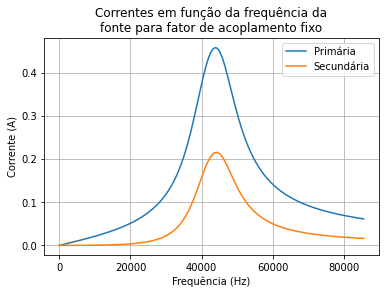

In [9]:
print('Frequência de resonância do transformador:\t\t %.1f Hz' % round(FREQUENCIA_RESONANTE, 1))
print('Corrente máxima na primária:\t\t\t%d mA @ %.1f Hz' % (round(abs(corrente_primaria_max_f * 1000)), round(f_corrente_primaria_max_f, 1)))
print('Corrente máxima na secundária:\t\t\t%d mA @ %.1f Hz' % (round(abs(corrente_secundaria_max_f * 1000)), round(f_corrente_secundaria_max_f, 1)))
        
plt.plot(frequencias, np.abs(correntes_primaria_f))
plt.plot(frequencias, np.abs(correntes_secundaria_f))

plt.xlabel('Frequência (Hz)')
plt.ylabel('Corrente (A)')
plt.title('Correntes em função da frequência da\nfonte para fator de acoplamento fixo')
plt.legend(['Primária', 'Secundária'])

plt.grid(True)

plt.show()

Corrente máxima na primária:		891 mA	@ k = 0.000
Corrente máxima na secundária:		184 mA	@ k = 0.122


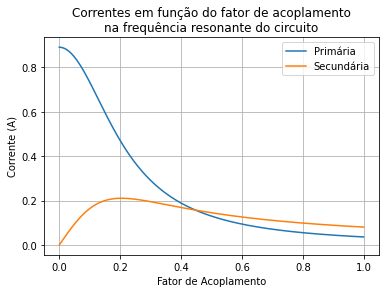

In [10]:
print('Corrente máxima na primária:\t\t%d mA\t@ k = %.3f' % (round(abs(corrente_primaria_max_k * 1000)), round(k_corrente_primaria_max_k, 3)))
print('Corrente máxima na secundária:\t\t%d mA\t@ k = %.3f' % (round(abs(corrente_secundaria_max_k * 1000)), round(k_corrente_secundaria_max_k, 3)))

plt.plot(fatores_acoplamento, np.abs(correntes_primaria_k))
plt.plot(fatores_acoplamento, np.abs(correntes_secundaria_k))

plt.xlabel('Fator de Acoplamento')
plt.ylabel('Corrente (A)')
plt.legend(['Primária', 'Secundária'])
plt.title('Correntes em função do fator de acoplamento\nna frequência resonante do circuito')

plt.grid(True)

plt.show()

### > Etapa 1.4

Frequência de resonância do transformador:		  42750.2 Hz
Potência máxima de entrada:			728 mW @ 43866.9 Hz
Potência máxima de saída:			270 mW @ 43572.0 Hz


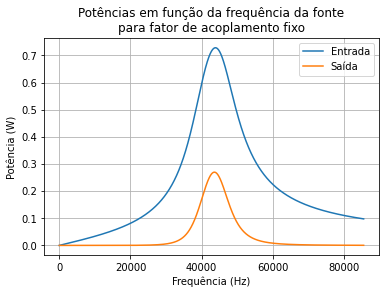

In [11]:
print('Frequência de resonância do transformador:\t\t  %.1f Hz' % round(FREQUENCIA_RESONANTE, 1))
print('Potência máxima de entrada:\t\t\t%d mW @ %.1f Hz' % (round(abs(potencia_entrada_max_f * 1000)), round(f_potencia_entrada_max_f, 1)))
print('Potência máxima de saída:\t\t\t%d mW @ %.1f Hz' % (round(abs(potencia_saida_max_f * 1000)), round(f_potencia_saida_max_f, 1)))

plt.plot(frequencias, potencias_entrada_f)
plt.plot(frequencias, potencias_saida_f)

plt.xlabel('Frequência (Hz)')
plt.ylabel('Potência (W)')
plt.legend(['Entrada', 'Saída'])
plt.title('Potências em função da frequência da fonte\npara fator de acoplamento fixo')

plt.grid(True)

plt.show()

Frequência de resonância do transformador:		42750.2 Hz
Eficiência energética máxima:			0.371 @ 43391.6 Hz


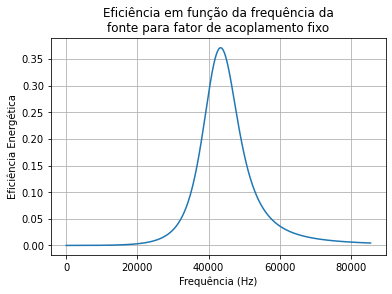

In [12]:
print('Frequência de resonância do transformador:\t\t%.1f Hz' % round(FREQUENCIA_RESONANTE, 1))
print('Eficiência energética máxima:\t\t\t%.3f @ %.1f Hz' % (round(abs(eficiencia_max_f), 3), round(f_eficiencia_max_f, 1)))

plt.plot(frequencias, eficiencias_f)

plt.xlabel('Frequência (Hz)')
plt.ylabel('Eficiência Energética')
plt.title('Eficiência em função da frequência da\nfonte para fator de acoplamento fixo')

plt.grid(True)

plt.show()

### > Etapa 1.5

Tensão máxima na carga:				7.300 V @ k = 0.200


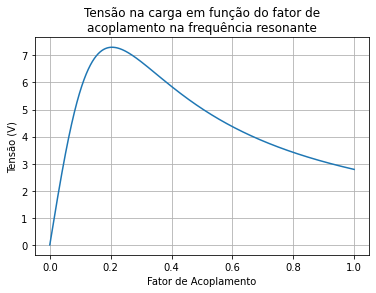

In [13]:
print('Tensão máxima na carga:\t\t\t\t%.3f V @ k = %.3f' % (round(abs(tensao_carga_max_k), 3), round(k_tensao_carga_max_k, 3)))

plt.plot(fatores_acoplamento, np.abs(tensoes_carga_k))

plt.xlabel('Fator de Acoplamento')
plt.ylabel('Tensão (V)')
plt.title('Tensão na carga em função do fator de\nacoplamento na frequência resonante')

plt.grid(True)

plt.show()

Eficiência energética máxima:				0.680 @ k = 3.000 1.0


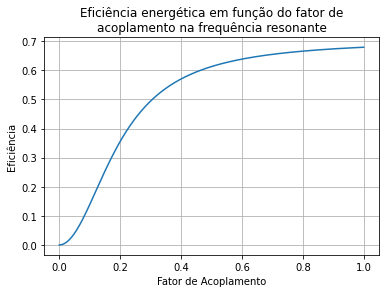

In [14]:
print('Eficiência energética máxima:\t\t\t\t%.3f @ k = %.3f' % (eficiencia_max_k, 3), round(k_eficiencia_max_k, 3))

plt.plot(fatores_acoplamento, eficiencias_k)

plt.xlabel('Fator de Acoplamento')
plt.ylabel('Eficiência')
plt.title('Eficiência energética em função do fator de\nacoplamento na frequência resonante')

plt.grid(True)

plt.show()